HEATMAP


In [1]:
import pandas as pd

df = pd.read_csv('per-capita-energy-use.csv')

df.shape
df.columns
df.head()




,Entity,Code,Year,Primary energy consumption per capita (kWh/person)
0,Afghanistan,AFG,1980,481.20862
1,Afghanistan,AFG,1981,610.63900
2,Afghanistan,AFG,1982,717.76640
3,Afghanistan,AFG,1983,905.12665
4,Afghanistan,AFG,1984,887.37100


In [2]:
# Dimensions del dataset
print("Shape:", df.shape)

# Tipus de dades
print("\nDtypes:")
print(df.dtypes)

# Valors nuls per columna
print("\nValors nuls per columna:")
print(df.isna().sum())

# Any mínim i màxim
print("\nRang d'anys:")
print(df['Year'].min(), df['Year'].max())

# Nombre d'entitats (països/regions)
print("\nNombre d'entitats úniques:", df['Entity'].nunique())

# Mostra 10 exemples d'entitats
print("\nPrimeres 10 entitats:")
print(df['Entity'].unique()[:10])



Shape: (11086, 4)

Dtypes:
Entity                                                 object
Code                                                   object
Year                                                    int64
Primary energy consumption per capita (kWh/person)    float64
dtype: object

Valors nuls per columna:
Entity                                                  0
Code                                                  644
Year                                                    0
Primary energy consumption per capita (kWh/person)      0
dtype: int64

Rang d'anys:
1965 2024

Nombre d'entitats úniques: 236

Primeres 10 entitats:
['Afghanistan' 'Africa' 'Albania' 'Algeria' 'American Samoa' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba']


In [3]:
# Llista de països seleccionats
paisos = [
    'Norway', 'United States', 'Germany', 'Spain',
    'China', 'India', 'Brazil', 'South Africa',
    'France', 'Australia'
]

# Filtrar sense pivotar (format llarg per Flourish)
df_sub = df[df['Entity'].isin(paisos)].copy()

# Exportar CSV
df_sub.to_csv("heatmap_energy_subset_long.csv", index=False)

print("Fitxer creat: heatmap_energy_subset_long.csv")
print(df_sub.head())
print(df_sub['Entity'].unique())
print("Files:", len(df_sub))


Fitxer creat: heatmap_energy_subset_long.csv
        Entity Code  Year  Primary energy consumption per capita (kWh/person)
530  Australia  AUS  1965                                          37487.190 
531  Australia  AUS  1966                                          38481.957 
532  Australia  AUS  1967                                          40056.914 
533  Australia  AUS  1968                                          41703.523 
534  Australia  AUS  1969                                          42569.410 
['Australia' 'Brazil' 'China' 'France' 'Germany' 'India' 'Norway'
 'South Africa' 'Spain' 'United States']
Files: 600


VORONOI


PNG guardat: airports_voronoi.png


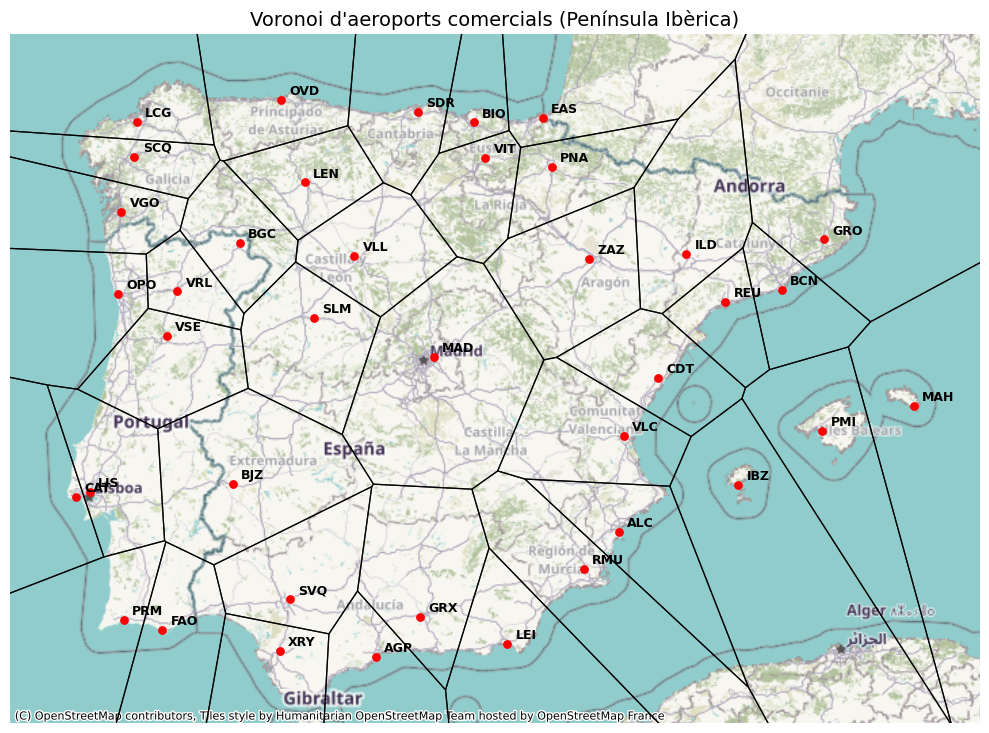

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
# ─────────────────────────────────────────────────────────────
# Voronoi aeroports comercials — Península Ibèrica (ES/PT)
# ─────────────────────────────────────────────────────────────
!pip install --quiet --upgrade shapely geopandas pyproj contextily

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.ops import voronoi_diagram
import contextily as cx

# 1) Carrega i filtre de dades
df = pd.read_csv("airports.csv")
df = df.dropna(subset=["longitude_deg","latitude_deg"])
df = df[(df["longitude_deg"] != 0) & (df["latitude_deg"] != 0)]

# País: només Espanya i Portugal
df = df[df["iso_country"].isin(["ES","PT"])].copy()

# Excloure Ceuta i Melilla si el camp existeix
if "iso_region" in df.columns:
    df = df[~df["iso_region"].isin(["ES-CE","ES-ML"])]

# Tipus i operativitat (SELECCIÓ FINAL: grans i mitjans comercials)
type_ok  = df["type"].isin(["large_airport","medium_airport"])
iata_ok  = df["iata_code"].notna() & (df["iata_code"].astype(str).str.len() > 0)
sched_ok = df.get("scheduled_service","").astype(str).str.lower().isin(["yes","y","true"])
df = df[type_ok & iata_ok & sched_ok].drop_duplicates(subset=["longitude_deg","latitude_deg"])

# Àmbit geogràfic: Península + Balears (sense Canàries per rendiment)
peni_mask = (
    (df["longitude_deg"] > -10.5) & (df["longitude_deg"] < 4.5) &
    (df["latitude_deg"]  > 35.0)  & (df["latitude_deg"]  < 44.5)
)
df = df[peni_mask].copy()

# 2) GeoDataFrame a Web Mercator
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude_deg"], df["latitude_deg"]),
    crs="EPSG:4326"
).to_crs(3857)

if len(gdf) < 3:
    raise ValueError("Hi ha massa pocs aeroports després del filtrat.")

# 3) Voronoi dins d’un bbox amb marge
minx, miny, maxx, maxy = gdf.total_bounds
pad = 120_000
bbox = Polygon([(minx-pad, miny-pad), (minx-pad, maxy+pad),
                (maxx+pad, maxy+pad), (maxx+pad, miny-pad)])

vor = voronoi_diagram(gdf.union_all(), envelope=bbox)
vor_gdf = gpd.GeoDataFrame(geometry=[geom for geom in vor.geoms], crs="EPSG:3857")

# 4) Assignació polígon-punt i preparació de geometries
joined = gpd.sjoin_nearest(gdf, vor_gdf, how="left", distance_col="dist")
vor_gdf["vor_id"] = range(len(vor_gdf))
joined["vor_id"]  = joined["index_right"]
final = joined.merge(vor_gdf, on="vor_id", suffixes=("_pt","_poly"))

# GeoDataFrames explícits amb la geometria correcta
final_pts  = gpd.GeoDataFrame(final.copy(), geometry="geometry_pt",   crs="EPSG:3857")
final_poly = gpd.GeoDataFrame(final.copy(), geometry="geometry_poly", crs="EPSG:3857")

# 5) Dibuix amb mapa OSM i etiquetes (SOLUCIÓ robusta: guardem abans de show)
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlim(minx-pad, maxx+pad)
ax.set_ylim(miny-pad, maxy+pad)

# Basemap OSM (si no carrega, segueix sense base i no trenca el PNG)
try:
    cx.add_basemap(ax, crs=final_poly.crs)
except Exception as e:
    print("No s'ha pogut carregar el basemap (segueixo sense base OSM):", e)

final_poly.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=0.9, alpha=0.9, zorder=3)
final_pts.plot(ax=ax, color="red", markersize=28, zorder=5)

for _, r in final_pts.iterrows():
    label = (str(r.get("iata_code","")) or str(r.get("name","")))
    x, y = r["geometry_pt"].x, r["geometry_pt"].y  # <- CLAU: usar geometry_pt
    ax.annotate(label, (x, y), xytext=(6, 4), textcoords="offset points",
                fontsize=9, fontweight="bold", color="black", zorder=6)

ax.set_title("Voronoi d'aeroports comercials (Península Ibèrica)", fontsize=14)
ax.set_axis_off()
plt.tight_layout()

# ---- GUARDA ABANS DE MOSTRAR (evita PNG en blanc) ----
fig.canvas.draw()  # força el render intern de la figura
fig.savefig("airports_voronoi.png", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
print("PNG guardat: airports_voronoi.png")

# Mostra a pantalla (opcional)
plt.show()

# Descarrega la imatge
from google.colab import files
files.download("airports_voronoi.png")


In [4]:
# ============================
# TILE GRID INTERACTIU (PLOTLY)
# ============================

# 0) Export a PNG amb Plotly: cal Kaleido compatible amb Plotly 5.x
!pip install --quiet "kaleido==0.2.1"

import numpy as np
import plotly.graph_objects as go

# --- Imports bàsics ---
import pandas as pd              # per llegir i manipular taules
import matplotlib.pyplot as plt  # (el fem servir només si vols mostrar altres coses)
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import TwoSlopeNorm  # per centrar la paleta a marge=0 (opcional)

# --- Llegir el CSV que acabes de pujar ---
# S'espera un CSV amb com a mínim: code, state, biden_pct, trump_pct
results_df = pd.read_csv("us2020_state_results.csv")

# Si no existeix la columna 'margin', la calculem (Biden% - Trump%)
if "margin" not in results_df.columns:
    results_df["margin"] = results_df["biden_pct"] - results_df["trump_pct"]

# (Opcional) columna 'winner' per comprovar ràpid qui guanya a cada estat
if "winner" not in results_df.columns:
    results_df["winner"] = np.where(results_df["margin"] >= 0, "Biden", "Trump")

# --- Definir les coordenades de la graella "us_state_grid1" ---
grid_rows = [
    (6,7,"AL","Alabama"),
    (7,2,"AK","Alaska"),
    (5,2,"AZ","Arizona"),
    (5,5,"AR","Arkansas"),
    (4,1,"CA","California"),
    (4,3,"CO","Colorado"),
    (3,10,"CT","Connecticut"),
    (4,10,"DE","Delaware"),
    (7,9,"FL","Florida"),
    (6,8,"GA","Georgia"),
    (7,1,"HI","Hawaii"),
    (2,2,"ID","Idaho"),
    (2,6,"IL","Illinois"),
    (3,6,"IN","Indiana"),
    (3,5,"IA","Iowa"),
    (5,4,"KS","Kansas"),
    (4,6,"KY","Kentucky"),
    (6,5,"LA","Louisiana"),
    (1,11,"ME","Maine"),
    (4,9,"MD","Maryland"),
    (2,10,"MA","Massachusetts"),
    (2,7,"MI","Michigan"),
    (2,5,"MN","Minnesota"),
    (6,6,"MS","Mississippi"),
    (4,5,"MO","Missouri"),
    (2,3,"MT","Montana"),
    (4,4,"NE","Nebraska"),
    (3,2,"NV","Nevada"),
    (1,10,"NH","New Hampshire"),
    (3,9,"NJ","New Jersey"),
    (5,3,"NM","New Mexico"),
    (2,9,"NY","New York"),
    (5,7,"NC","North Carolina"),
    (2,4,"ND","North Dakota"),
    (3,7,"OH","Ohio"),
    (6,4,"OK","Oklahoma"),
    (3,1,"OR","Oregon"),
    (3,8,"PA","Pennsylvania"),
    (3,11,"RI","Rhode Island"),
    (5,8,"SC","South Carolina"),
    (3,4,"SD","South Dakota"),
    (5,6,"TN","Tennessee"),
    (7,4,"TX","Texas"),
    (4,2,"UT","Utah"),
    (1,9,"VT","Vermont"),
    (4,8,"VA","Virginia"),
    (2,1,"WA","Washington"),
    (4,7,"WV","West Virginia"),
    (1,6,"WI","Wisconsin"),
    (3,3,"WY","Wyoming"),
    (5,9,"DC","District of Columbia"),
]

grid_df = pd.DataFrame(grid_rows, columns=["row","col","code","name"])
grid_df.to_csv("us_tile_grid_coords.csv", index=False)  # si vols lliurar-la com a fitxer

# 2) Merge (per si vens d'una cel·la neta)
merged = pd.merge(
    grid_df[["row","col","code","name"]],
    results_df[["code","state","biden_pct","trump_pct","margin"]],
    on="code",
    how="left"
)

# 3) Coordenades de ploteig (origen a dalt)
merged["plot_row"] = merged["row"].max() - merged["row"]   # invertir files
merged["plot_col"] = merged["col"].astype(float)

# 4) Rangs de color simètrics al voltant de 0
vmax = float(merged["margin"].abs().max())

# 5) Traç únic amb tiles quadrats
fig = go.Figure(
    data = [
        go.Scatter(
            x = merged["plot_col"],
            y = merged["plot_row"],
            mode = "markers+text",
            text = merged["code"],
            textposition = "middle center",
            textfont = dict(size=11),
            marker = dict(
                symbol = "square",
                size = 60,
                color = merged["margin"],
                colorscale = "RdBu",
                cmin = -vmax,
                cmax =  vmax,
                line = dict(width=1, color="white"),
                showscale = True,
                colorbar = dict(title="Vote margin (pp)")
            ),
            customdata = np.stack([
                merged["state"], merged["code"],
                merged["biden_pct"], merged["trump_pct"], merged["margin"]
            ], axis=-1),
            hovertemplate =
                "<b>%{customdata[0]}</b> (%{customdata[1]})<br>" +
                "Biden: %{customdata[2]}%<br>" +
                "Trump: %{customdata[3]}%<br>" +
                "<b>Margin:</b> %{customdata[4]:.2f} punts<extra></extra>"
        )
    ]
)

# 6) Layout
fig.update_layout(
    title = "2020 U.S. Presidential Election — Tile Grid Map",
    width = 950, height = 650,
    plot_bgcolor = "white",
    xaxis = dict(visible=False, constrain="domain"),
    yaxis = dict(visible=False, scaleanchor="x", scaleratio=1),
    margin = dict(l=10, r=10, t=60, b=10)
)

# 7) Mostra la figura interactiva
fig.show()

# 8) GUARDAR PNG AMB PLOTLY (no matplotlib)
#    Atenció: fem servir write_image (requereix kaleido, que hem instal·lat a dalt)
fig.write_image("tile_grid.png", scale=3)  # PNG d'alta resolució
print("PNG guardat: tile_grid.png")

# 9) Descarregar el PNG
from google.colab import files
files.download("tile_grid.png")





/tmp/ipython-input-528355562.py:151: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




PNG guardat: tile_grid.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>